In [1]:
import pandas as pd
import numpy as np
import psycopg2
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.optimize import minimize
pd.set_option('mode.chained_assignment', None)
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
conn = psycopg2.connect("dbname=nhl_db")
cur = conn.cursor()

In [3]:
cur.execute("""
    SELECT
        team,
        season,
        game_date,
        win,
        loss,
        ot_loss,
        goals_for,
        goals_against
    FROM summary
    WHERE playoffs = FALSE
    AND season >= '2012/13'
""")

In [4]:
df = pd.DataFrame(data=cur.fetchall(), columns=["team", "season", "date", "wins", "losses", "ot_losses", "goals_for", "goals_against"])

In [5]:
df.head()

,team,season,date,wins,losses,ot_losses,goals_for,goals_against
0,BOS,2021/22,2022-03-12,1,0,0,3,2
1,BOS,2021/22,2022-01-08,1,0,0,5,2
2,OTT,2021/22,2021-12-11,1,0,0,4,0
3,OTT,2021/22,2022-04-29,1,0,0,4,2
4,OTT,2021/22,2021-10-29,1,0,0,4,1


In [6]:
conn.close()

In [7]:
season_df = df.groupby(["team", "season"])[["wins", "losses", "ot_losses", "goals_for", "goals_against"]].sum().reset_index()

In [8]:
season_df["games_played"] = season_df["wins"] + season_df["losses"] + season_df["ot_losses"]
season_df["losses"] = season_df["losses"] + season_df["ot_losses"]
season_df.drop("ot_losses", axis=1, inplace=True)

In [9]:
season_df["win_pc"] = season_df["wins"] / season_df["games_played"]

In [10]:
season_df.head()

,team,season,wins,losses,goals_for,goals_against,games_played,win_pc
0,ANA,2012/13,30,18,134,115,48,0.625000
1,ANA,2013/14,54,28,263,203,82,0.658537
2,ANA,2014/15,51,31,228,221,82,0.621951
3,ANA,2015/16,46,36,215,188,82,0.560976
4,ANA,2016/17,46,36,220,197,82,0.560976


In [11]:
def pythagoreanExpectation(row, alpha=2):
    return pow(row.goals_for,alpha) / (pow(row.goals_for,alpha) + pow(row.goals_against,alpha))

In [12]:
def optimizePythagoreanExpectation(group, column_name):
    def f(alpha):
        pyth_exp = group.apply(lambda x: pythagoreanExpectation(x, alpha=alpha), axis=1)
    
        mse = mean_absolute_error(group["win_pc"], pyth_exp)

        return mse
    
    res = minimize(f, x0=2.0)
    group[column_name] = res.x[0]

    return group

In [13]:
season_df = season_df.groupby(["season"], group_keys=True).apply(lambda x: optimizePythagoreanExpectation(x, "league_pe_alpha"))
season_df.reset_index(drop = True, inplace = True)

In [14]:
season_df = season_df.groupby(["season", "team"], group_keys=True).apply(lambda x: optimizePythagoreanExpectation(x, "team_pe_alpha"))
season_df.reset_index(drop = True, inplace = True)

In [15]:
season_df.head()

,team,season,wins,losses,goals_for,goals_against,games_played,win_pc,league_pe_alpha,team_pe_alpha
0,ANA,2012/13,30,18,134,115,48,0.625000,2.07064,3.340746
1,ARI,2012/13,21,27,121,125,48,0.437500,2.07064,7.727238
2,BOS,2012/13,28,20,127,106,48,0.583333,2.07064,1.861554
3,BUF,2012/13,21,27,118,139,48,0.437500,2.07064,1.534376
4,CAR,2012/13,19,29,127,159,48,0.395833,2.07064,1.881730


In [16]:
seasons = season_df.season.unique()
teams = season_df.team.unique()

In [17]:
# # plot
# fig, ax = plt.subplots(figsize=(10,6))

# # ax.set_title("Optimized alpha values by season")
# ax.set_xlabel("Season")
# ax.set_ylabel("Alpha")

# fig.suptitle('Optimized alpha values by season')
# fig.autofmt_xdate()

# for team in teams:
#     team_df = season_df.loc[season_df.team == team, :]
#     ax.plot(team_df["season"].unique(), team_df["team_pe_alpha"].unique(), linewidth=1.0, alpha=0.2)
    
# ax.plot(season_df["season"].unique(), season_df["league_pe_alpha"].unique(), linewidth=2.0)

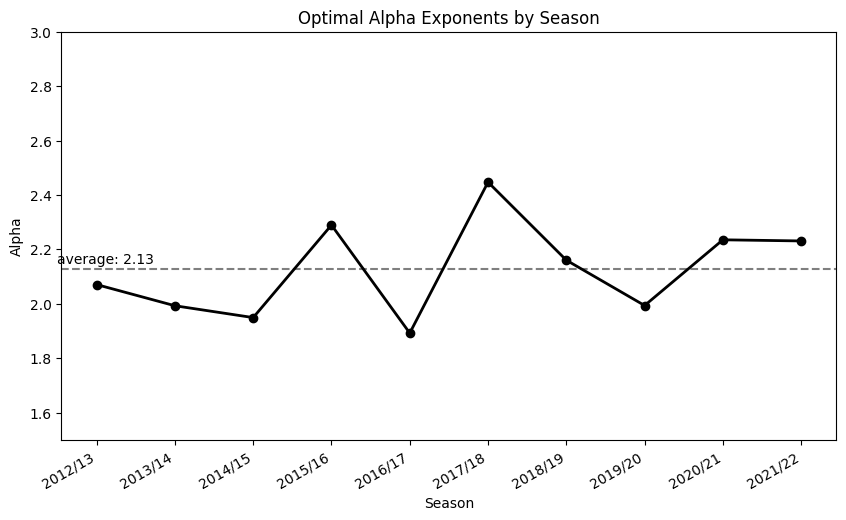

In [45]:
# plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Optimal Alpha Exponents by Season")
ax.set_xlabel("Season")
ax.set_ylabel("Alpha")
ax.set_ylim([1.5, 3.0])
fig.autofmt_xdate()

ax.plot(season_df["season"].unique(), season_df["league_pe_alpha"].unique(), 'o-', linewidth=2.0, color="black")
ax.axhline(season_df.league_pe_alpha.mean(), alpha=.5, c="black", linestyle='--')
ax.text(-0.5,1.01*season_df.league_pe_alpha.mean(), f"average: {round(season_df.league_pe_alpha.mean(),2)}")

plt.show()